# Analysis of Data and Visualization
This notebook contains the explanatory variable analysis and model training aspect of the project.

In [2]:
# Initialize notebook and define libraries
import pandas as pd
import requests
import json
from datetime import datetime
import pytz
import math
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import recall_score
from IPython.display import display, Image

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Repeated Functions
These functions are utilized various times in the explanatory data analysis phase

In [3]:
# Normalize function normalizes values for use in analysis, required due to errors in USD conversions
def normalize(data):
    min_values = data.apply(lambda col: col.min(), axis=0)
    max_values = data.apply(lambda col: col.max(), axis=0)
    normalized = (data - min_values)/(max_values-min_values)
    
    return normalized


# Rename function removes a common string from all columns in a dataframe
def rename(data, string='USDT_PERP.A'):
    data.columns = data.columns.str.replace(string, '')
    
    return data

## Import all CSV files created in preparation phase
Files to import:

- Close and volume data: 'close volume.csv'
- Long short ratios: 'long short.csv'
- Liquidation data: 'liquidations.csv'
- Open interest data: 'open interest.csv'
- Funding rate data: 'funding rate.csv'
- Older Bitcoin close data: 'older btc closes.csv'

In [4]:
# Import the close volume dataset
cv_data = rename(pd.read_csv('close volume.csv').set_index('t'))

# View the dataframe
cv_data.head()

,PEOPLE_close,PEOPLE_volume,OMG_close,OMG_volume,BAL_close,BAL_volume,REN_close,REN_volume,CRV_close,CRV_volume,...,1000XEC_close,1000XEC_volume,ENS_close,ENS_volume,KLAY_close,KLAY_volume,ARPA_close,ARPA_volume,ANT_close,ANT_volume
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.12081,366228687,6.281,7454170.5,19.593,2154143.0,0.5638,69983534,6.038,1.036064e+08,...,0.11298,145318525,41.085,974072.9,1.3920,1.100433e+07,0.09996,161401473,13.054,6.937153e+06
2022-01-03,0.12359,1620448582,6.189,8643863.6,19.154,1712422.2,0.5814,144762720,6.507,1.369175e+08,...,0.11641,321535079,39.300,845290.1,1.3991,4.737673e+07,0.10030,164729769,11.969,9.752468e+06
2022-01-04,0.11922,592464466,6.025,7992392.2,19.314,1491750.5,0.5786,75248782,6.077,1.093639e+08,...,0.11271,145264202,38.666,1268892.0,1.4024,1.512157e+07,0.09913,228777805,11.048,6.519602e+06
2022-01-05,0.10148,1091596364,5.563,9675976.9,17.529,1319813.0,0.5179,91429399,5.394,1.059897e+08,...,0.10421,153789159,33.780,2120905.6,1.3459,3.414819e+07,0.09138,204856943,10.260,7.712332e+06
2022-01-06,0.10189,1627929359,5.644,9182662.0,17.671,1350058.6,0.5190,63385696,5.398,9.355741e+07,...,0.10317,107552156,33.171,1549395.1,1.3470,2.448704e+07,0.09215,137694411,10.855,1.984296e+07


In [5]:
# Import the long short ratio dataset
lsr_data = rename(pd.read_csv('long short.csv'))
lsr_data = lsr_data.rename(columns={'Unnamed: 0':'t'}).set_index('t')

# View the dataframe
lsr_data.head()

,PEOPLE_ls_ratio,OMG_ls_ratio,BAL_ls_ratio,REN_ls_ratio,CRV_ls_ratio,STORJ_ls_ratio,RLC_ls_ratio,SXP_ls_ratio,KAVA_ls_ratio,RSR_ls_ratio,...,COTI_ls_ratio,DENT_ls_ratio,NKN_ls_ratio,IOTX_ls_ratio,CTSI_ls_ratio,1000XEC_ls_ratio,ENS_ls_ratio,KLAY_ls_ratio,ARPA_ls_ratio,ANT_ls_ratio
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,4.8754,5.2112,2.5174,3.6339,1.1758,3.2337,2.5026,1.1478,0.9324,3.7733,...,3.7778,4.7537,3.4072,3.7259,3.0371,7.6281,5.5833,1.5349,5.2657,0.9260
2022-01-03,5.5359,4.6022,1.7115,3.5893,1.9886,2.9078,2.7793,1.8121,2.5174,3.6882,...,4.3967,5.1958,3.4863,4.2466,3.0967,6.1480,5.3694,1.6096,5.2150,0.7224
2022-01-04,5.8213,5.2696,2.3693,4.7904,1.5265,3.8193,4.0968,3.2644,2.1114,3.8333,...,4.3792,4.3505,4.4259,6.2993,3.2499,5.4144,6.0771,1.7078,5.0060,1.8547
2022-01-05,7.6881,5.6667,2.6792,4.5279,2.1496,4.1813,3.3066,3.9480,1.2795,3.9628,...,5.2933,4.8241,4.2165,5.9204,3.0225,6.3584,6.1174,1.9638,5.7385,2.5920
2022-01-06,5.4851,5.1958,2.7341,3.9727,3.3122,4.0125,3.6468,3.5809,3.0967,4.7241,...,4.5218,4.8241,4.5127,5.1996,3.6948,6.3475,4.1706,1.6048,5.7159,3.2589


In [6]:
# Import the liquidation dataset
liq_data = rename(pd.read_csv('liquidations.csv'))
liq_data = liq_data.rename(columns={'Unnamed: 0':'t'}).set_index('t')

# View the dataframe
liq_data.head()

,PEOPLE_longliq,PEOPLE_shortliq,REN_longliq,REN_shortliq,CRV_longliq,CRV_shortliq,STORJ_longliq,STORJ_shortliq,RLC_longliq,RLC_shortliq,...,C98_longliq,C98_shortliq,MANA_longliq,MANA_shortliq,HBAR_longliq,HBAR_shortliq,DYDX_longliq,DYDX_shortliq,COTI_longliq,COTI_shortliq
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,438865.0,59767.0,15226.0,39673.0,195064.4,143533.8,29917.0,21160.0,3693.7,2303.0,...,5853.0,1889.0,22516.0,17497.0,62358.0,73906.0,1632.1,10535.0,76885.0,26845.0
2022-01-03,2109983.0,974617.0,279242.0,134105.0,210800.7,259412.7,41807.0,1551.0,25650.7,356.9,...,40169.0,77.0,145557.0,11590.0,341073.0,36839.0,33328.0,5.5,143211.0,26779.0
2022-01-04,578912.0,102480.0,88626.0,26938.0,198043.0,50376.3,23616.0,3004.0,28555.9,12089.4,...,14214.0,20723.0,212523.0,9730.0,217191.0,195997.0,11749.7,463.0,273429.0,147684.0
2022-01-05,5147538.0,458971.0,1065753.0,38093.0,527518.7,71815.9,239899.0,4017.0,86365.0,8362.9,...,205544.0,44861.0,653472.0,88627.0,1822568.0,98327.0,154618.6,15609.7,818186.0,104982.0
2022-01-06,1382699.0,1372846.0,80025.0,22704.0,118396.4,73880.6,21597.0,7564.0,8362.6,487.3,...,32085.0,832.0,412973.0,513847.0,352089.0,95069.0,25594.7,2284.8,156865.0,81615.0


In [7]:
# Import the open interest dataset
oi_data = rename(pd.read_csv('open interest.csv').set_index('t'))

# View the dataframe
oi_data.head()

,PEOPLE_oi,OMG_oi,BAL_oi,REN_oi,CRV_oi,STORJ_oi,RLC_oi,SXP_oi,KAVA_oi,RSR_oi,...,COTI_oi,DENT_oi,NKN_oi,IOTX_oi,CTSI_oi,1000XEC_oi,ENS_oi,KLAY_oi,ARPA_oi,ANT_oi
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,68563069,3122112.0,394437.4,12762654,11017123.3,4303733,1455285.7,14236229.6,2282008.7,288405487,...,24172953,2019996834,9848830,78125566,7436356,83094075,351933.8,4321786.3,32398052,645657.7
2022-01-03,84182338,3096458.2,384553.9,14505797,11152569.3,4120101,1420726.0,14268516.7,2209351.1,289906166,...,21221001,1905116342,10282931,84111450,7851700,93536412,347383.5,5824068.2,30491808,808693.9
2022-01-04,81084356,3237728.9,372170.7,13498759,10325255.0,4272890,1415021.0,14445695.4,2713160.5,258782132,...,24055189,1907226788,11399335,85097349,7937815,87752202,340777.5,4473165.7,35025899,795920.3
2022-01-05,70931487,2975032.7,334429.9,12753033,10156233.9,3614683,1385405.5,11848814.3,1801207.7,259929606,...,21131656,1698262118,11749733,72868738,7325916,94212904,268054.4,4590931.4,30029965,627958.7
2022-01-06,85988267,2939160.8,330922.5,11631507,9852081.5,3821826,1468365.1,11186872.7,1921671.0,271609057,...,18719064,1752508930,9642903,77749107,6832195,95515343,280190.9,3535328.5,27366157,853021.3


In [8]:
# Import the funding rate dataset
fr_data = rename(pd.read_csv('funding rate.csv').set_index('t'))

# View the dataframe
fr_data.head()

,PEOPLE_fr,OMG_fr,BAL_fr,REN_fr,CRV_fr,STORJ_fr,RLC_fr,SXP_fr,KAVA_fr,RSR_fr,...,COTI_fr,DENT_fr,NKN_fr,IOTX_fr,CTSI_fr,1000XEC_fr,ENS_fr,KLAY_fr,ARPA_fr,ANT_fr
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.01,0.01,0.010000,0.01,0.01,-0.019553,0.010000,0.01,0.01,0.01,...,0.01,0.01,0.010000,0.01,0.01,-0.085688,0.01,0.01,0.010000,0.01
2022-01-03,0.01,0.01,0.010000,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,...,0.01,0.01,0.010000,0.01,0.01,0.008957,0.01,0.01,0.010000,0.01
2022-01-04,0.01,0.01,0.010000,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,...,0.01,0.01,0.010000,0.01,0.01,-0.049702,0.01,0.01,0.010000,0.01
2022-01-05,0.01,0.01,0.010000,0.01,0.01,0.010000,0.010000,0.01,0.01,0.01,...,0.01,0.01,0.010000,0.01,0.01,-0.108208,0.01,0.01,0.010000,0.01
2022-01-06,0.01,0.01,-0.075603,0.01,0.01,0.007112,0.008475,0.01,0.01,0.01,...,0.01,0.01,-0.040119,0.01,0.01,0.004942,0.01,0.01,0.002022,0.01


In [9]:
# Import the older Bitcoin closes dataset
old_btc_data = rename(pd.read_csv('older btc closes.csv').set_index('t'))

# View the dataframe
old_btc_data.head()

,BTC_close
t,
2019-09-12,10415.13
2019-09-13,10341.34
2019-09-14,10332.25
2019-09-15,10302.22
2019-09-16,10249.27


# Explanatory Variable Analysis
This section of the notebook creates new metrics from the imported data to use in training the model to predict when someone should consider selling their bitcoin.

## Working with Close Data

In [10]:
clo_columns = cv_data.columns.str.endswith('close')
close = cv_data.loc[:,clo_columns]

close.head()

,PEOPLE_close,OMG_close,BAL_close,REN_close,CRV_close,STORJ_close,RLC_close,SXP_close,KAVA_close,RSR_close,...,COTI_close,DENT_close,NKN_close,IOTX_close,CTSI_close,1000XEC_close,ENS_close,KLAY_close,ARPA_close,ANT_close
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.12081,6.281,19.593,0.5638,6.038,1.9222,3.2022,2.1397,4.2825,0.030917,...,0.38391,0.003935,0.38240,0.12576,0.7140,0.11298,41.085,1.3920,0.09996,13.054
2022-01-03,0.12359,6.189,19.154,0.5814,6.507,1.8502,3.2541,1.9458,4.5371,0.030232,...,0.38970,0.004098,0.36894,0.12280,0.6949,0.11641,39.300,1.3991,0.10030,11.969
2022-01-04,0.11922,6.025,19.314,0.5786,6.077,1.7866,3.4296,1.8598,5.0233,0.031137,...,0.39353,0.003930,0.37705,0.12171,0.7141,0.11271,38.666,1.4024,0.09913,11.048
2022-01-05,0.10148,5.563,17.529,0.5179,5.394,1.6276,3.1051,1.6570,4.3873,0.028397,...,0.36682,0.003537,0.33877,0.11009,0.6429,0.10421,33.780,1.3459,0.09138,10.260
2022-01-06,0.10189,5.644,17.671,0.5190,5.398,1.6501,3.0122,1.6932,4.2019,0.027587,...,0.36993,0.003556,0.33181,0.10977,0.6489,0.10317,33.171,1.3470,0.09215,10.855


### Weekly Median Returns

In [11]:
wmrs = pd.DataFrame()

wmrs = (close.diff(7) / close.shift(7)) * 100
non_btc = wmrs.loc[:, ~wmrs.columns.str.endswith('BTC_close')]

wmrs['Weekly Median Returns'] = non_btc.median(axis=1)
wmrs['BTC Weekly Returns'] = wmrs['BTC_close']
wmrs['BTC Close'] = cv_data['BTC_close']

wmrs = wmrs.iloc[:,-3:]
wmrs = wmrs.dropna()

wmrs.head()

,Weekly Median Returns,BTC Weekly Returns,BTC Close
t,,,
2022-01-09,-16.463085,-11.482191,41851.22
2022-01-10,-19.907214,-9.999309,41801.55
2022-01-11,-14.507639,-6.835056,42700.68
2022-01-12,-2.718220,1.057144,43880.72
2022-01-13,-6.214846,-1.266690,42534.32


### Relative Strength Index (RSI)
This function uses the close prices for each token in order to return the Relative Strength Index.

Relative Strength Index (RSI) definition: is a momentum indicator, comparing the a security's strength on days when the prices rise to its strength on days when prices go down. The RSI provides technical traders signals about bullish and bearish price momentum. An RSI above 70 indicates an asset is overbought, and an RSI below 30 indicates an asset is oversold. From: https://www.nasdaq.com

The Relative Strength Index is computed using the following equation:
![RSI Equation](rsi_formula.jpeg)

In [12]:
#Incorporating RSI Metric
def calculate_rsi(df, close_column_suffix='_close', window=14):
    """
    Calculate Relative Strength Index (RSI) for each asset in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the time series data with columns for different assets.
    - close_column_suffix: The suffix used in the column names for closing prices of each asset.
    - window: The window size for calculating the RSI.

    Returns:
    - pandas DataFrame with RSI values for each asset.
    """
    rsi_df = pd.DataFrame()  # Initialize an empty DataFrame to store RSI values

    # Iterate over columns in the input DataFrame
    for column in df.columns:
        if close_column_suffix in column:
            # Extract the symbol name from the column name
            symbol_name = column.replace(close_column_suffix, '')

            # Calculate RSI for the current asset
            close_prices = df[column]
            delta = close_prices.diff(1)
            gains = delta.where(delta > 0, 0)
            losses = -delta.where(delta < 0, 0)
            avg_gains = gains.rolling(window=window, min_periods=1).mean()
            avg_losses = losses.rolling(window=window, min_periods=1).mean()
            rs = avg_gains / avg_losses
            rsi = 100 - (100 / (1 + rs))

            # Add RSI values to the result DataFrame
            rsi_df[f'{symbol_name}_RSI'] = rsi

    return rsi_df.iloc[2:,:]

rsi_result = calculate_rsi(close)

rsi_result

,PEOPLE_RSI,OMG_RSI,BAL_RSI,REN_RSI,CRV_RSI,STORJ_RSI,RLC_RSI,SXP_RSI,KAVA_RSI,RSR_RSI,...,COTI_RSI,DENT_RSI,NKN_RSI,IOTX_RSI,CTSI_RSI,1000XEC_RSI,ENS_RSI,KLAY_RSI,ARPA_RSI,ANT_RSI
t,,,,,,,,,,,,,,,,,,,,,
2022-01-04,38.881119,0.000000,26.711185,86.274510,52.169077,0.000000,100.000000,0.000000,100.000000,56.918239,...,100.000000,49.244713,37.598516,0.000000,50.130548,48.106592,0.000000,100.000000,22.516556,0.000000
2022-01-05,11.169144,0.000000,6.711409,21.701603,29.646018,0.000000,41.203117,0.000000,53.805927,20.900693,...,26.479494,22.513812,13.550543,0.000000,17.534247,21.944978,0.000000,15.545590,3.671706,0.000000
2022-01-06,12.608696,10.137672,11.955661,22.749392,29.823455,7.095553,35.266749,6.976296,47.420305,17.607004,...,32.276876,24.495289,12.138901,0.000000,21.818182,20.575885,0.000000,16.911765,11.066800,17.556801
2022-01-07,11.916324,8.709677,14.691216,14.274809,23.828715,5.580357,27.543605,5.792927,55.428944,12.548530,...,17.779330,20.044053,8.936639,0.000000,15.517241,15.983225,0.000000,9.207366,6.702899,12.066518
2022-01-08,9.761322,7.472325,16.547842,11.790668,19.840604,4.932047,25.213438,5.156695,60.044751,11.004377,...,13.486598,16.961789,7.685018,0.000000,13.298153,14.521592,0.000000,14.350453,5.288232,9.649692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,50.596659,46.628131,57.455429,54.343514,50.607287,57.335084,54.123919,47.058824,49.825541,64.500942,...,60.379275,56.393443,63.352671,55.486726,54.300169,47.932131,46.265840,60.112360,46.421756,60.969793
2023-12-02,56.371490,52.241641,61.459101,59.675505,58.422939,51.347305,58.086343,51.997292,56.681708,68.953386,...,62.328996,61.111111,56.659669,63.542494,60.399334,55.228426,53.697093,59.328969,53.810742,67.038328
2023-12-03,53.964758,49.981420,61.824818,54.806492,55.147059,51.079672,54.588531,47.328244,52.664462,66.157989,...,57.606228,60.333333,49.767214,60.128102,57.876106,54.769231,46.260538,60.742496,48.150193,66.572438


In [13]:
rsi_median = pd.DataFrame(rsi_result.drop('BTC_RSI',axis=1).apply(lambda row: np.median(row),axis=1))
btc_rsi = pd.DataFrame(rsi_result.loc[:,'BTC_RSI'])

In [14]:
btc_closes = close['BTC_close']

rsis = rsi_median.merge(right=btc_rsi,left_index=True,right_index=True,how='left')
rsis = rsis.merge(right=btc_closes,left_index=True,right_index=True,how='left')

rsis = rsis.rename(columns = {0:'Median RSI','BTC_RSI':'BTC RSI','BTC_close':'BTC Close'})

rsis.head()

,Median RSI,BTC RSI,BTC Close
t,,,
2022-01-04,18.736162,0.000000,45833.42
2022-01-05,5.766884,0.000000,43421.69
2022-01-06,11.802366,0.000000,43080.01
2022-01-07,9.072003,0.000000,41553.86
2022-01-08,8.667355,2.289803,41688.05


### Exponential Moving Average (EMA)
This function uses the close prices for each token to return the Exponential Moving Average.

Exponential Moving Average (EMA) definition: type of moving average that places a greater weight and significance on the most recent data points. From: https://www.investopedia.com.

For this model, we will be using an Exponential Moving Average for a period of 14 days.

The Exponential Moving Average is computed using the following equation:

![EMA Equation](ema_formula.jpeg)

In [15]:
def calculate_ema(df, close_column_suffix='_close', ema_window=14):
    """
    Calculate Exponential Moving Average (EMA) for each asset in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the time series data with columns for different assets.
    - close_column_suffix: The suffix used in the column names for closing prices of each asset.
    - ema_window: The window size for calculating the EMA.

    Returns:
    - pandas DataFrame with EMA values for each asset.
    """
    ema_df = pd.DataFrame()  # Initialize an empty DataFrame to store EMA values

    # Iterate over columns in the input DataFrame
    for column in df.columns:
        if close_column_suffix in column:
            # Extract the symbol name from the column name
            symbol_name = column.replace(close_column_suffix, '')

            # Calculate EMA for the current asset
            close_prices = df[column]
            
            # Use adjust=True to include the first days in the window
            ema = close_prices.ewm(span=ema_window, min_periods=1, adjust=True).mean()

            # Add EMA values to the result DataFrame
            ema_df[f'{symbol_name}_EMA'] = ema

    return ema_df

In [16]:
ema_result = calculate_ema(close)
ema_result.head()

,PEOPLE_EMA,OMG_EMA,BAL_EMA,REN_EMA,CRV_EMA,STORJ_EMA,RLC_EMA,SXP_EMA,KAVA_EMA,RSR_EMA,...,COTI_EMA,DENT_EMA,NKN_EMA,IOTX_EMA,CTSI_EMA,1000XEC_EMA,ENS_EMA,KLAY_EMA,ARPA_EMA,ANT_EMA
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.120810,6.281000,19.593000,0.563800,6.038000,1.922200,3.202200,2.139700,4.282500,0.030917,...,0.383910,0.003935,0.382400,0.125760,0.714000,0.112980,41.085000,1.392000,0.099960,13.054000
2022-01-03,0.122299,6.231714,19.357821,0.573229,6.289250,1.883629,3.230004,2.035825,4.418893,0.030550,...,0.387012,0.004022,0.375189,0.124174,0.703768,0.114818,40.128750,1.395804,0.100142,12.472750
2022-01-04,0.121123,6.152749,19.341081,0.575280,6.208170,1.846563,3.306250,1.968583,4.649778,0.030774,...,0.389502,0.003987,0.375900,0.123233,0.707715,0.114012,39.569975,1.398323,0.099756,11.928491
2022-01-05,0.115114,5.972328,18.786715,0.557726,5.959092,1.779576,3.244713,1.873261,4.569479,0.030047,...,0.382563,0.003849,0.364541,0.119212,0.687886,0.111014,37.798658,1.382286,0.097193,11.418052
2022-01-06,0.111664,5.886668,18.495626,0.547623,5.812704,1.745796,3.184050,1.826283,4.473578,0.029405,...,0.379267,0.003773,0.356001,0.116749,0.677715,0.108967,36.591309,1.373080,0.095877,11.271153


In [17]:
ema_median = pd.DataFrame(ema_result.drop('BTC_EMA',axis=1).apply(lambda row: np.median(row),axis=1))
btc_ema = pd.DataFrame(ema_result.loc[:,'BTC_EMA'])

#btc_closes = close_data['BTCUSDT_PERP.A_close']

emas = ema_median.merge(right=btc_ema,left_index=True,right_index=True,how='left')
emas = emas.merge(right=btc_closes,left_index=True,right_index=True,how='left')

emas = emas.rename(columns = {0:'Median EMA','BTC_EMA':'BTC EMA','BTC_close':'BTC Close'})

emas.head()

,Median EMA,BTC EMA,BTC Close
t,,,
2022-01-02,2.340550,47280.000000,47280.00
2022-01-03,2.328175,46833.112500,46445.81
2022-01-04,2.338230,46451.226570,45833.42
2022-01-05,2.274588,45524.405874,43421.69
2022-01-06,2.238744,44886.666730,43080.01


## Working with Volume Data


In [18]:
vol_columns = cv_data.columns.str.endswith('volume')
volume = normalize(cv_data.loc[:,vol_columns])

volume.head()

,PEOPLE_volume,OMG_volume,BAL_volume,REN_volume,CRV_volume,STORJ_volume,RLC_volume,SXP_volume,KAVA_volume,RSR_volume,...,COTI_volume,DENT_volume,NKN_volume,IOTX_volume,CTSI_volume,1000XEC_volume,ENS_volume,KLAY_volume,ARPA_volume,ANT_volume
t,,,,,,,,,,,,,,,,,,,,,
2022-01-02,0.000000,0.007847,0.031959,0.003056,0.026901,0.004679,0.009460,0.034593,0.021850,0.003858,...,0.008478,0.016613,0.000370,0.015925,0.000000,0.002888,0.011777,0.000798,0.002413,0.032205
2022-01-03,0.016959,0.009916,0.023391,0.008964,0.037486,0.003241,0.006874,0.026910,0.019051,0.003429,...,0.016016,0.041600,0.001506,0.031668,0.000050,0.008489,0.009420,0.008779,0.002503,0.046510
2022-01-04,0.003059,0.008783,0.019111,0.003472,0.028731,0.002215,0.019911,0.017004,0.039209,0.005033,...,0.019587,0.038404,0.008755,0.019651,0.002531,0.002887,0.017174,0.001702,0.004227,0.030084
2022-01-05,0.009808,0.011710,0.015776,0.004750,0.027658,0.004650,0.011898,0.019693,0.036225,0.007067,...,0.025281,0.040709,0.012973,0.038221,0.006498,0.003158,0.032771,0.005877,0.003583,0.036144
2022-01-06,0.017060,0.010852,0.016363,0.002535,0.023708,0.004195,0.007518,0.012978,0.013822,0.003943,...,0.011964,0.038050,0.008961,0.030362,0.001994,0.001688,0.022309,0.003757,0.001775,0.097779


### Meme Coin Volume Ratios

In [19]:
meme_coins = ['DOGE_volume','1000SHIB_volume'] # Two prominent meme coins

memes = pd.DataFrame()
memes['Meme Volume Ratio'] = volume.apply(lambda row: sum(row[coin] for coin in meme_coins)/
                                                     row['BTC_volume'] if row['BTC_volume']!=0 else 10, axis=1)
memes['BTC Close'] = cv_data['BTC_close']

memes.head()                      

,Meme Volume Ratio,BTC Close
t,,
2022-01-02,0.354544,47280.00
2022-01-03,0.381842,46445.81
2022-01-04,0.302925,45833.42
2022-01-05,0.389687,43421.69
2022-01-06,0.590312,43080.01


## Working with Long Short Ratio Data

In [20]:
lsrs = pd.DataFrame()

lsrs['Mean LSR'] = lsr_data.mean(axis=1)
lsrs['BTC LSR'] = lsr_data.loc[:,'BTC_ls_ratio']
lsrs['BTC Close'] = cv_data['BTC_close']

lsrs.head()

,Mean LSR,BTC LSR,BTC Close
t,,,
2022-01-02,3.889292,2.8432,47280.00
2022-01-03,3.802677,2.8911,46445.81
2022-01-04,4.349442,4.3677,45833.42
2022-01-05,4.504622,4.1680,43421.69
2022-01-06,4.518870,3.7824,43080.01


## Working with Liquidation Data

In [21]:
lliq_columns = liq_data.columns.str.endswith('longliq')
sliq_columns = liq_data.columns.str.endswith('shortliq')

long_liq = normalize(liq_data.loc[:,lliq_columns])
short_liq = normalize(liq_data.loc[:,sliq_columns])

liqs = pd.DataFrame()
liqs['Total Long Liquid'] = long_liq.sum(axis=1)
liqs['Total Short Liquid'] = short_liq.sum(axis=1)
liqs['BTC Close'] = cv_data['BTC_close']

liqs.head()

,Total Long Liquid,Total Short Liquid,BTC Close
t,,,
2022-01-02,1.403569,1.072167,47280.00
2022-01-03,3.309129,1.779828,46445.81
2022-01-04,3.824364,1.854995,45833.42
2022-01-05,13.020305,2.717092,43421.69
2022-01-06,3.524649,2.235112,43080.01


## Working with Opening Interest Data

In [22]:
open_interest = normalize(oi_data)
non_btc = open_interest.loc[:, ~open_interest.columns.str.endswith('BTC_oi')]

ois = pd.DataFrame()
ois['Total Open Interest'] = non_btc.sum(axis=1)
ois['BTC Open Interest'] = open_interest['BTC_oi']
ois['BTC Close'] = cv_data['BTC_close']
ois['OI Ratio'] = ois.apply(lambda row: row['Total Open Interest'] / row['BTC Open Interest'] 
                            if row['BTC Open Interest'] != 0 else 0, axis=1)

ois.head()

,Total Open Interest,BTC Open Interest,BTC Close,OI Ratio
t,,,,
2022-01-02,4.427474,0.073755,47280.00,60.029691
2022-01-03,5.080928,0.135351,46445.81,37.538976
2022-01-04,5.170654,0.151689,45833.42,34.087279
2022-01-05,3.956818,0.118894,43421.69,33.280170
2022-01-06,4.363319,0.133219,43080.01,32.753076


## Working with Funding Rate Data
This function returns the Annual Percentage Rate for each token based on the funding rate. The funding rate is calculated every 8 hours in the Coinalyze dataset, therefore the annual rate will be the funding rate multiplied by 3 to receive the daily rate and multiplied again by 365.25 to obtain the annual rate.

In [23]:
def convert_to_apr(rate):
    apr = rate * 3 * 365.25
    return apr

funding = fr_data.apply(lambda row: row.apply(convert_to_apr), axis=1)
non_btc = funding.loc[:, ~funding.columns.str.endswith('BTC_fr')] 

In [24]:
frs = pd.DataFrame()

frs['Median FR'] = non_btc.median(axis=1)
frs['BTC FR'] = funding.loc[:,'BTC_fr']
frs['BTC Close'] = cv_data['BTC_close']

frs.head()

,Median FR,BTC FR,BTC Close
t,,,
2022-01-02,10.9575,10.9575,47280.00
2022-01-03,10.9575,10.9575,46445.81
2022-01-04,10.9575,10.9575,45833.42
2022-01-05,10.9575,10.9575,43421.69
2022-01-06,10.9575,10.9575,43080.01


## Working with Older Bitcoin Close Data

### Simple Moving Average (SMA)

In [25]:
btc_closes = pd.DataFrame()

btc_closes['BTC SMA'] = old_btc_data['BTC_close'].rolling(window=20).mean()
btc_closes = btc_closes.dropna()
btc_closes['Diff SMA'] = 100*(old_btc_data['BTC_close']-btc_closes['BTC SMA'])/btc_closes['BTC SMA']
btc_closes['BTC Close'] = old_btc_data['BTC_close']

btc_closes.head()

,BTC SMA,Diff SMA,BTC Close
t,,,
2019-10-01,9403.8810,-11.844907,8290.00
2019-10-02,9300.7315,-10.199106,8352.14
2019-10-03,9194.6780,-10.597522,8220.27
2019-10-04,9084.5935,-10.501664,8130.56
2019-10-05,8975.5895,-9.508562,8122.14


# Consolidation of Data

In [26]:
# Create a list of DataFrames created above
dfs = [wmrs, rsis, liqs, memes, btc_closes, ois, lsrs, frs, emas]

# Merge all Dataframes together only returning rows containing all features
full_data = pd.concat(dfs, axis=1, join='inner')
full_data = full_data.loc[:, ~full_data.columns.duplicated()] # Remove duplicate columns

# View the Dataframe
full_data

,Weekly Median Returns,BTC Weekly Returns,BTC Close,Median RSI,BTC RSI,Total Long Liquid,Total Short Liquid,Meme Volume Ratio,BTC SMA,Diff SMA,Total Open Interest,BTC Open Interest,OI Ratio,Mean LSR,BTC LSR,Median FR,BTC FR,Median EMA,BTC EMA
t,,,,,,,,,,,,,,,,,,,
2022-01-09,-16.463085,-11.482191,41851.22,16.214313,4.936665,1.722586,1.871387,0.481659,46853.5480,-10.676519,4.536014,0.102128,44.414874,4.093668,2.9793,10.9575,10.957500,2.099449,43261.179144
2022-01-10,-19.907214,-9.999309,41801.55,13.922615,4.896290,6.360438,2.758649,0.381020,46499.8680,-10.103938,4.984904,0.105966,47.042506,3.671095,2.8329,10.9575,10.957500,2.067494,42992.427489
2022-01-11,-14.507639,-6.835056,42700.68,25.431213,17.160621,1.370350,2.972028,0.863178,46206.4175,-7.587123,5.089135,0.114105,44.600639,3.945355,2.6417,10.9575,10.957500,2.074618,42941.306428
2022-01-12,-2.718220,1.057144,43880.72,34.971047,29.151507,1.043282,2.913580,1.369731,45859.5575,-4.314995,5.381825,0.115040,46.782262,3.360678,1.9674,10.9575,-5.853497,2.087305,43099.295685
2022-01-13,-6.214846,-1.266690,42534.32,31.612051,25.019424,4.586022,2.238563,1.560806,45445.8460,-6.406583,5.484570,0.108685,50.463020,3.373897,2.3602,10.9575,-6.663256,2.080232,43007.478269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-28,8.831724,5.806587,37812.10,51.345372,60.720777,3.170625,2.000709,0.765270,37042.3700,2.077972,34.796695,0.151229,230.092750,2.590274,1.2046,10.9575,10.957500,0.528178,37109.232581
2023-11-29,1.649285,1.132482,37837.10,45.823948,49.704503,2.250832,1.376058,0.916064,37098.2500,1.991603,36.034958,0.166487,216.442510,2.342178,0.6793,10.9575,10.957500,0.530501,37206.281570
2023-11-30,2.185126,1.132881,37716.80,50.242160,61.642387,1.683393,0.940881,1.183153,37117.5700,1.614411,36.516637,0.166199,219.715991,2.407382,0.8077,10.9575,10.957500,0.533021,37274.350694


In [27]:
# Save the data in a csv to be used in the model building notebook
full_data.to_csv('wrangled.csv')

# Data Visualizations

## Repeated Functions

These functions are utilized various time in the data visualization phase. It will plot the bitcoin closing price along side the given feature to help visualize any possible trends

In [28]:
def plot_dual_axis(label, plot_data, x_data, y1_data, y1_label, y2_data, y2_label, color1='orange', color2='blue'):
    """
    Plot data on dual axes.

    Parameters:
    - plot_data: DataFrame containing the data to be plotted.
    - x_data: Values for the x-axis.
    - y1_data: Column name for the first y-axis data.
    - y2_data: Column name for the second y-axis data.
    - y1_label: Label for the first y-axis.
    - y2_label: Label for the second y-axis.
    - color1: Color for the first line plot (default: 'orange').
    - color2: Color for the second line plot (default: 'blue').
    """
    plt.figure(figsize=(10, 5))
    plt.title(f'{label}', fontsize=18)

    ax = sns.lineplot(x=x_data, y=plot_data[y1_data], label=y1_label, color=color1)
    ax2 = ax.twinx()

    sns.lineplot(ax=ax2, x=x_data, y=plot_data[y2_data], label=y2_label, color=color2)

    # Set x-axis ticker locator to control the number of ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Adjust the number of ticks as needed

    # Adjust legend and grid settings
    ax.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.grid(True)
    ax2.grid(False)

    ax.set_xlabel('Date-Time', fontsize=18)

    return ax



def plot_triple_axis(label, data, x_data, y1_data, y1_label, y2_data, y2_label, y3_data, y3_label, color1='orange', color2='blue', color3='red'):
    """
    Plot data on triple axes with an additional line plot.

    Parameters:
    - data: DataFrame containing the data to be plotted.
    - x_data: Values for the x-axis.
    - y1_data: Column name for the first y-axis data.
    - y2_data: Column name for the second y-axis data.
    - y1_label: Label for the first y-axis.
    - y2_label: Label for the second y-axis.
    - y3_data: Column name for the third y-axis data.
    - y3_label: Label for the third y-axis.
    - color1: Color for the first line plot (default: 'orange').
    - color2: Color for the second line plot (default: 'blue').
    - color3: Color for the third line plot (default: 'red').

    Returns:
    - Axes object.
    """
    ax = plot_dual_axis(label, data, x_data, y1_data, y1_label, y2_data, y2_label, color1, color2)
    
    sns.lineplot(ax=ax, x=x_data, y=data[y3_data], label=y3_label, color=color3)

    ax.legend(loc='upper left', fontsize=14)

    return ax

## Weekly Median Returns Plot

Comparing the BTC Price with its Weekly Median Return gives us an inside on the short term momentus of the given Bitcoin as well as to any potential trends.

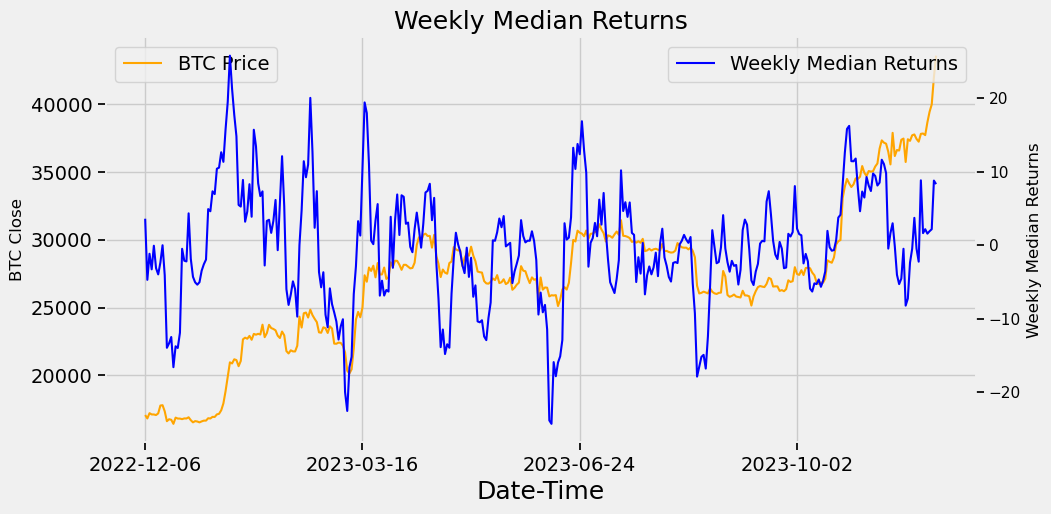

In [29]:
# Plot Weekly Median Returns
selected_wmrs = wmrs[-365:]
plot_dual_axis('Weekly Median Returns',selected_wmrs, selected_wmrs.index,'BTC Close','BTC Price',
               'Weekly Median Returns','Weekly Median Returns')
plt.show()

## Median RSI Plot

Plotting BTC with the median RSI gives us an indicator to wheather the asset is overbought or oversold. Analyzing BTC price against median RSI values aids in identifying potential reversal points or confirming the strength of an existing trend.

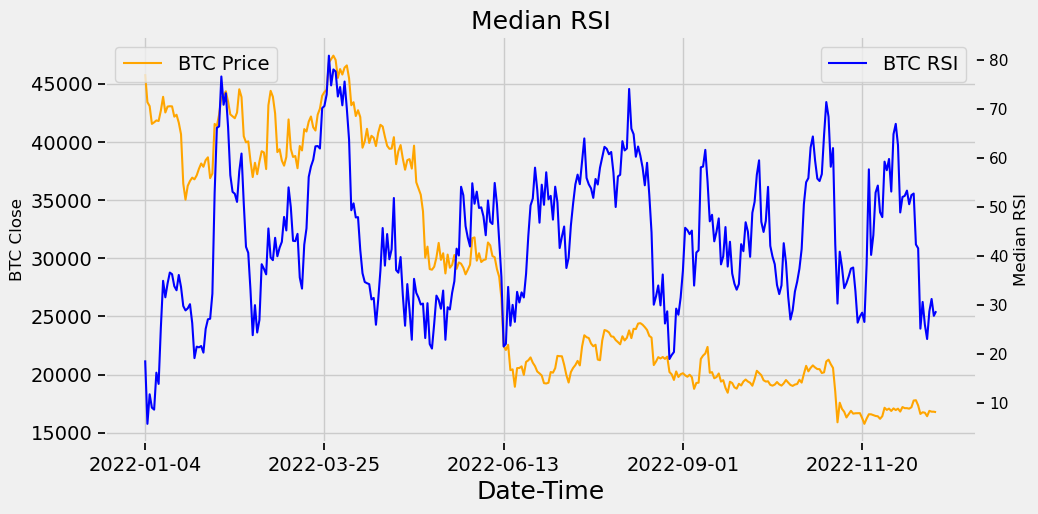

In [30]:
# Plot Median RSI
plot_dual_axis('Median RSI', rsis[0:354], rsis.index[0:354],'BTC Close','BTC Price','Median RSI','BTC RSI')
plt.show()

## Meme Volume Ratio Plot

The meme volume ratio provides insights into the market sentiment, particularly the risk-on behavior, as it measures the total daily volume across meme coins relative to BTC daily volume.When comparing the meme volume ratio with BTC price, investors can gain a better understanding of how speculative interest in meme coins might impact the broader cryptocurrency market. 

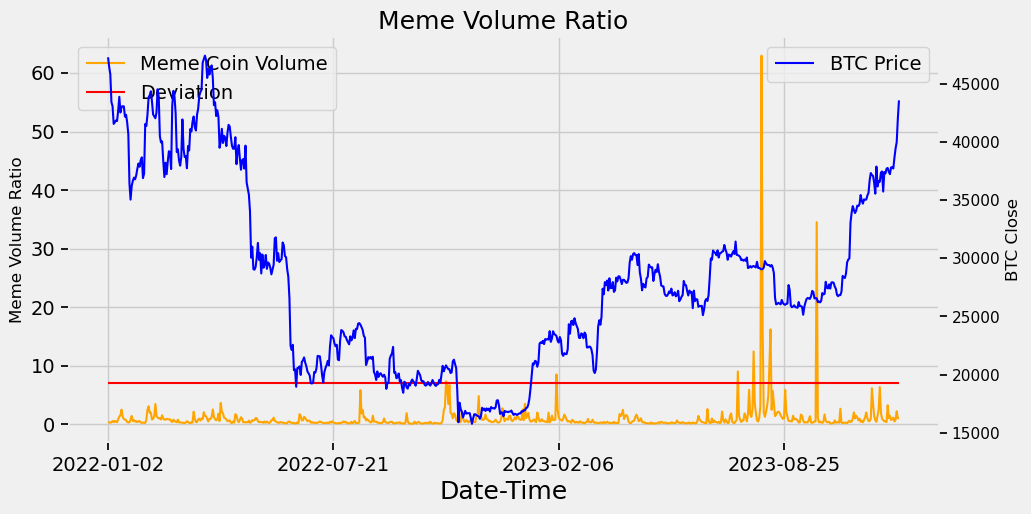

In [31]:
# Plot Meme Coin Volumes
memes['deviation'] = np.mean(memes['Meme Volume Ratio']) + 2 * np.std(memes['Meme Volume Ratio'])
plot_triple_axis('Meme Volume Ratio', memes, memes.index, 'Meme Volume Ratio','Meme Coin Volume','BTC Close','BTC Price',
               'deviation','Deviation')
plt.show()

# Long-Short Ratio Plot

When comparing the long-short ratio with BTC price, investors can gain insights into market sentiment. A high long-short ratio in a bull market might indicate optimism, suggesting that traders expect Bitcoin's price to rise. Conversely, a low long-short ratio in a bear market might suggest pessimism, with traders anticipating a decline in Bitcoin's price.

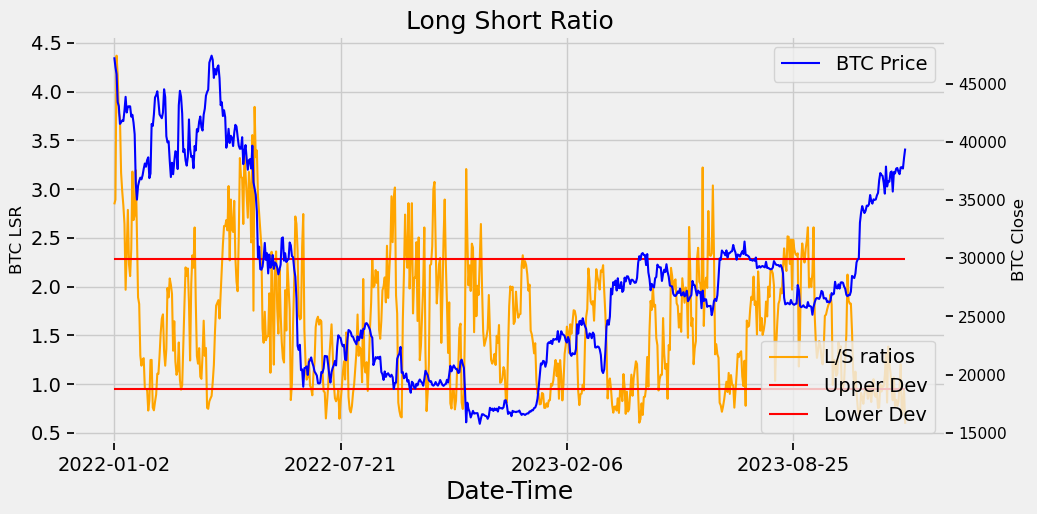

In [32]:
# Plot Long Short Ratios
lsrs['upper deviation'] = np.mean(lsrs['BTC LSR']) + np.std(lsrs['BTC LSR'])
lsrs['lower deviation'] = np.mean(lsrs['BTC LSR']) - np.std(lsrs['BTC LSR'])
ax = plot_triple_axis('Long Short Ratio',lsrs, lsrs.index, 'BTC LSR', 'L/S ratios','BTC Close', 'BTC Price','upper deviation','Upper Dev')
sns.lineplot(data=lsrs, x=lsrs.index, y='lower deviation', label='Lower Dev', color='r',ax=ax)
ax.legend(loc='lower right', fontsize=14)
plt.show()

## Total Long Liquidation Plot

Analyzing the relationship between total long liquidations and BTC price provides a gauge of market sentiment and the intensity of trading activity. It allows investors to consider the impact of forced liquidations on Bitcoin's price trends and make more informed decisions based on the prevailing market conditions.

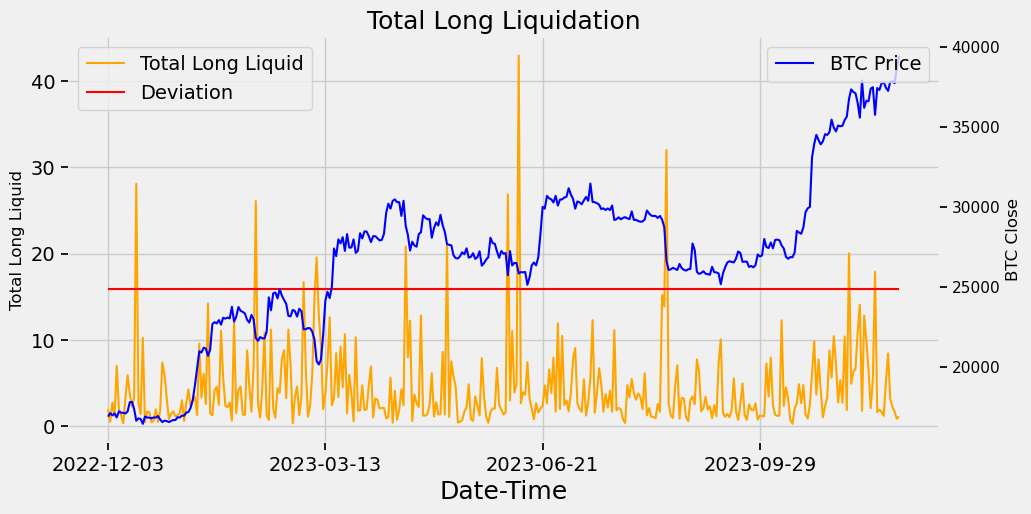

In [33]:
liqs_mean = liqs['Total Long Liquid'].mean()
liqs_std = liqs['Total Long Liquid'].std()

# Add a column for upper deviation (mean + 2 * std)
liqs['upper deviation'] = liqs_mean + 2 * liqs_std

# Plot Total Long Liquidations
plot_triple_axis('Total Long Liquidation',liqs[-365:], liqs.index[-365:], 'Total Long Liquid', 'Total Long Liquid',
               'BTC Close', 'BTC Price',
               'upper deviation', 'Deviation')
plt.show()

## Total Short Liquidations Plot

Analyzing the interplay between total short liquidations and BTC price offers valuable information about market sentiment and the intensity of trading activity. It enables investors to assess the impact of forced liquidations on Bitcoin's price trends and make more informed decisions based on the prevailing market conditions.

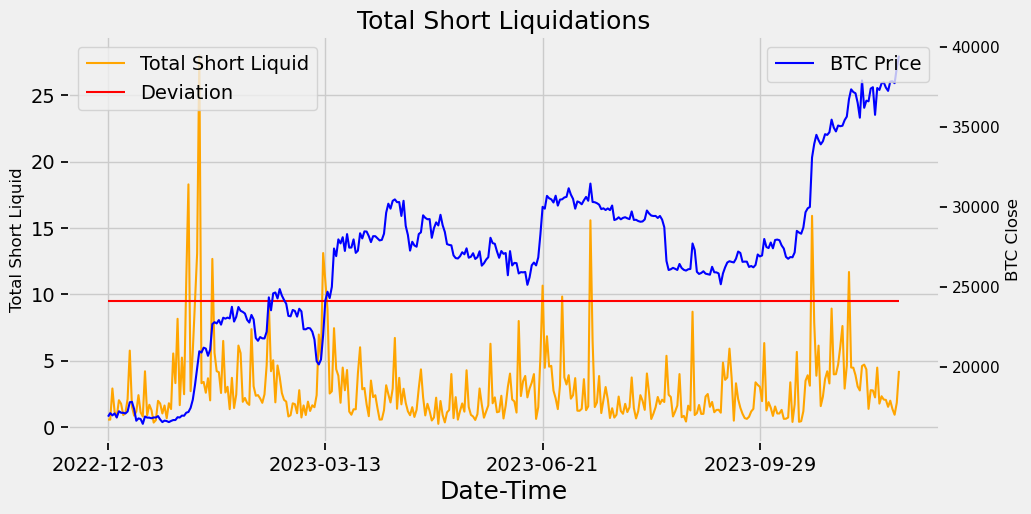

In [34]:
# Plot Total Short Liquidations
liqs_short_mean = liqs['Total Short Liquid'].mean()
liqs_short_std = liqs['Total Short Liquid'].std()

# Add a column for upper deviation (mean + 2 * std)
liqs['upper deviation'] = liqs_short_mean + 2 * liqs_short_std

# Plot Total Long Liquidations
plot_triple_axis('Total Short Liquidations',liqs[-365:], liqs.index[-365:], 'Total Short Liquid', 'Total Short Liquid',
               'BTC Close', 'BTC Price',
               'upper deviation', 'Deviation')

# Show the plot
plt.show()

## Total Open Interest Plot

Examining the relationship between total open interest and BTC price offers a valuable gauge of market sentiment, reflecting the active involvement of traders in the futures market. This analysis enables investors to assess the overall enthusiasm or caution prevailing in the market. By understanding the level of engagement from traders, investors are empowered to make more informed decisions, navigating the dynamic conditions of the Bitcoin market with greater insight.

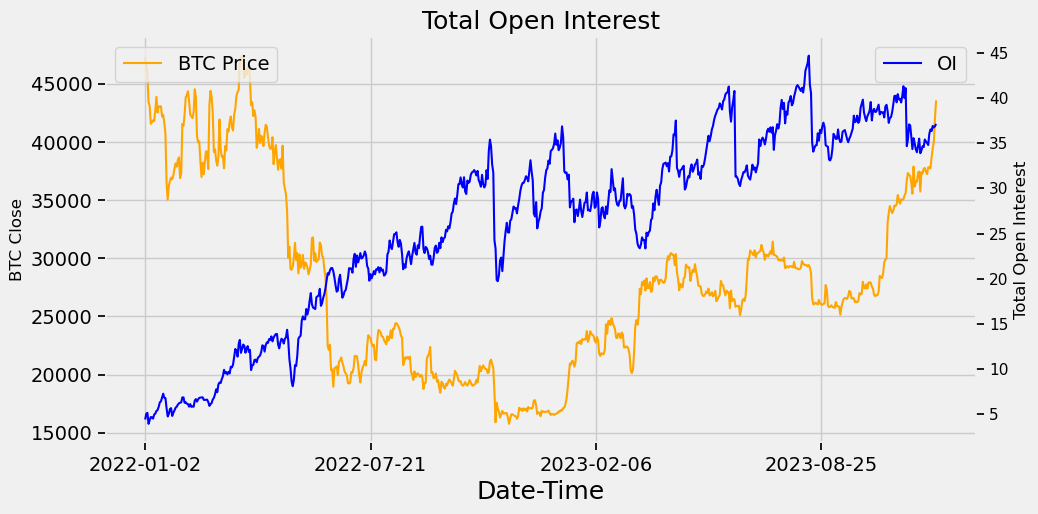

In [35]:
# Plot Total Open Interest
plot_dual_axis('Total Open Interest',ois, ois.index, 'BTC Close', 'BTC Price', 'Total Open Interest', 'OI')
plt.show()

## Funding Rate Plot

Analyzing the relationship between funding rates and BTC price equips investors with a valuable tool to grasp market dynamics, foresee potential shifts in sentiment, and make well-informed decisions based on the prevailing conditions in the Bitcoin market. This insight allows investors to navigate the complexities of the market, staying ahead of potential changes and adapting their strategies to the evolving landscape of Bitcoin pricing.

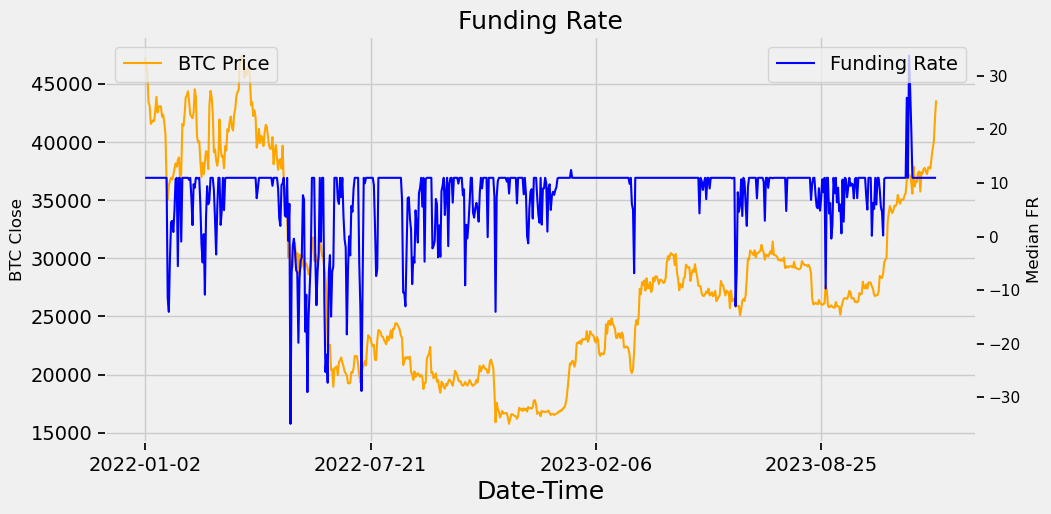

In [36]:
# Plot Funding Rate
plot_dual_axis('Funding Rate', frs, frs.index, 'BTC Close', 'BTC Price', 'Median FR','Funding Rate')
plt.show()

## 20 Day Simple Moving Average Plot

Examining how the 20-day Simple Moving Average (SMA) interacts with BTC price offers investors a valuable tool for understanding the current trend, pinpointing potential trend reversals, and enhancing decision-making through technical analysis in the Bitcoin market. This analysis provides insights that enable investors to navigate market dynamics more effectively, staying attuned to trend shifts and making informed choices based on the technical indicators presented by the 20-day SMA.

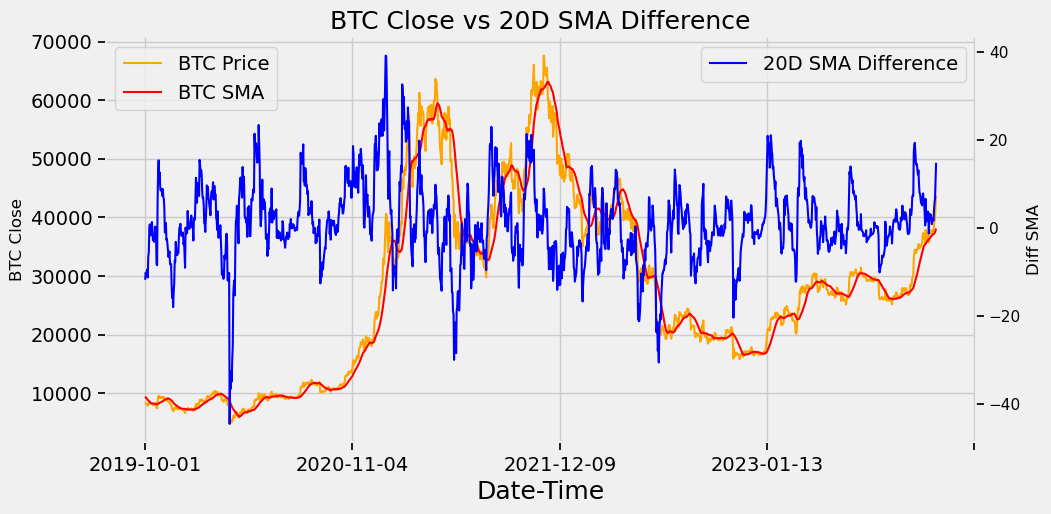

In [37]:
# Plot the dual-axis plot using your custom function
plot_triple_axis('BTC Close vs 20D SMA Difference',btc_closes, btc_closes.index, 'BTC Close', 'BTC Price', 
                       'Diff SMA', '20D SMA Difference', 'BTC SMA', 'BTC SMA')

# Show the plot
plt.show()

## Median Exponential Moving Average Plot

Analyzing the interplay between the median EMA and BTC price provides investors with a tool to understand the momentum, spot potential changes in trend direction, and make informed decisions based on the evolving dynamics in the Bitcoin market. 

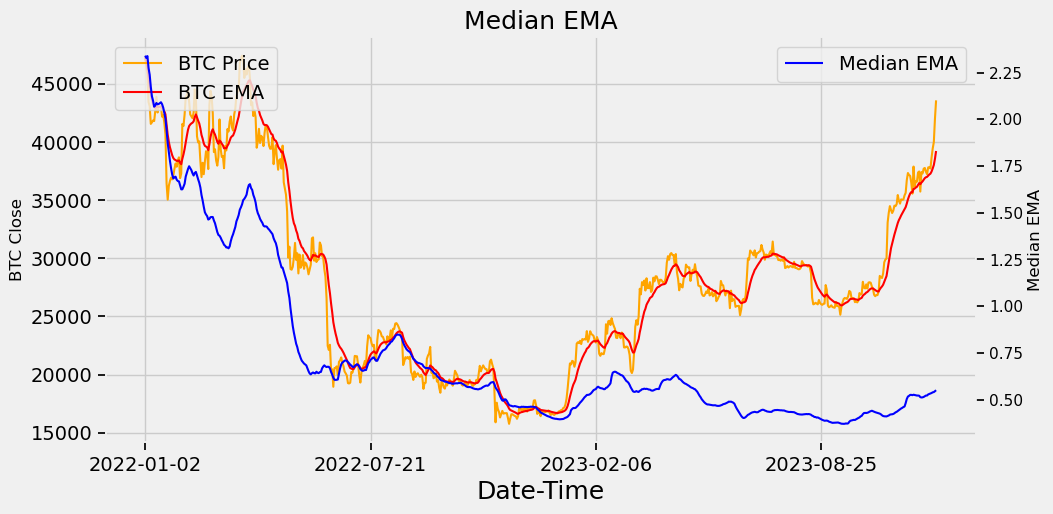

In [38]:
plot_triple_axis('Median EMA', emas, emas.index, 'BTC Close','BTC Price','Median EMA','Median EMA','BTC EMA','BTC EMA')
plt.show()